In [3]:
#Load necessary library
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import tensorflow as tf
import keras

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")


# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(51)

2024-07-30 22:00:19.339614: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 22:00:19.339750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 22:00:19.502080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#Assign all folder paths to a variable
#Train data
train_pneumonia_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
train_normal_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL'

#Test data
test_pneumonia_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'
test_normal_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL'

#Validation data
val_pneumonia_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA'
val_normal_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL'


#Extract the images from path and assign to variables
#Train data
train_pn = [os.path.join(train_pneumonia_dir, i) for i in os.listdir(train_pneumonia_dir)]
train_nn = [os.path.join(train_normal_dir, i) for i in os.listdir(train_normal_dir)]

#Test data
test_pn = [os.path.join(test_pneumonia_dir, i) for i in os.listdir(test_pneumonia_dir)]
test_nn = [os.path.join(test_normal_dir, i) for i in os.listdir(test_normal_dir)]

#Validation data
val_pn = [os.path.join(val_pneumonia_dir, i) for i in os.listdir(val_pneumonia_dir)]
val_nn = [os.path.join(val_normal_dir, i) for i in os.listdir(val_normal_dir)]

In [5]:
#Explore the total number of images
Total_images = len(train_pn + train_nn + test_pn + test_nn + val_pn + val_nn)
Total_pneumonia = len(train_pn + test_pn + val_pn)
Total_normal = len(train_nn + test_nn + val_nn)

print('The numeber of total images is', Total_images)
print('The total number of pneumonia images is', Total_pneumonia)
print('The total number of normal images is', Total_normal)


The numeber of total images is 5856
The total number of pneumonia images is 4273
The total number of normal images is 1583


In [8]:
train_set = train_pn + train_nn
test_set = test_pn + test_nn
val_set = val_pn + val_nn

In [9]:
#Explore the pixel size of the images; open first image for the dataset
train_img = cv2.imread(train_set[0], cv2.IMREAD_GRAYSCALE)
test_img = cv2.imread(test_set[0], cv2.IMREAD_GRAYSCALE)
val_img = cv2.imread(val_set[0], cv2.IMREAD_GRAYSCALE)

train_height, train_width = train_img.shape
test_height, test_width = test_img.shape
val_height, val_width = val_img.shape

print('The pixel size of the 1st image in train set is', f"Width: {train_width} pixels", 'and', f"Height: {train_height} pixels")
print('The pixel size of the 1st image in test set is', f"Width: {test_width} pixels", 'and', f"Height: {test_height} pixels")
print('The pixel size of the 1st image in val set is', f"Width: {val_width} pixels", 'and', f"Height: {val_height} pixels")

The pixel size of the 1st image in train set is Width: 1024 pixels and Height: 712 pixels
The pixel size of the 1st image in test set is Width: 1624 pixels and Height: 1104 pixels
The pixel size of the 1st image in val set is Width: 1152 pixels and Height: 664 pixels


In [10]:
#Preprocessing
#Create a function to assign the images to their respective labels(Normal = 0; Pneumonia = 1), to resize the images to 128 x 128, to normalize the image
def preprocess_image(image_list, new_size=(224, 224)):

    X = []  # images
    y = []  # labels

    for image in image_list:
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, new_size)
        img_normalize = img_resized.astype(np.float32)/255.0
        X.append(img_normalize)


        if 'NORMAL' in image:
           y.append(0)
        elif 'IM' in image:
           y.append(0)
        elif 'virus' in image or 'bacteria' in image:
           y.append(1)
        else:
            print(f"Warning: Unable to load image {image}")

    return X, y

In [11]:
#Preprocess the train, test and val dataset
X,y = preprocess_image(train_set)
A,b = preprocess_image(test_set)
C,d = preprocess_image(val_set)

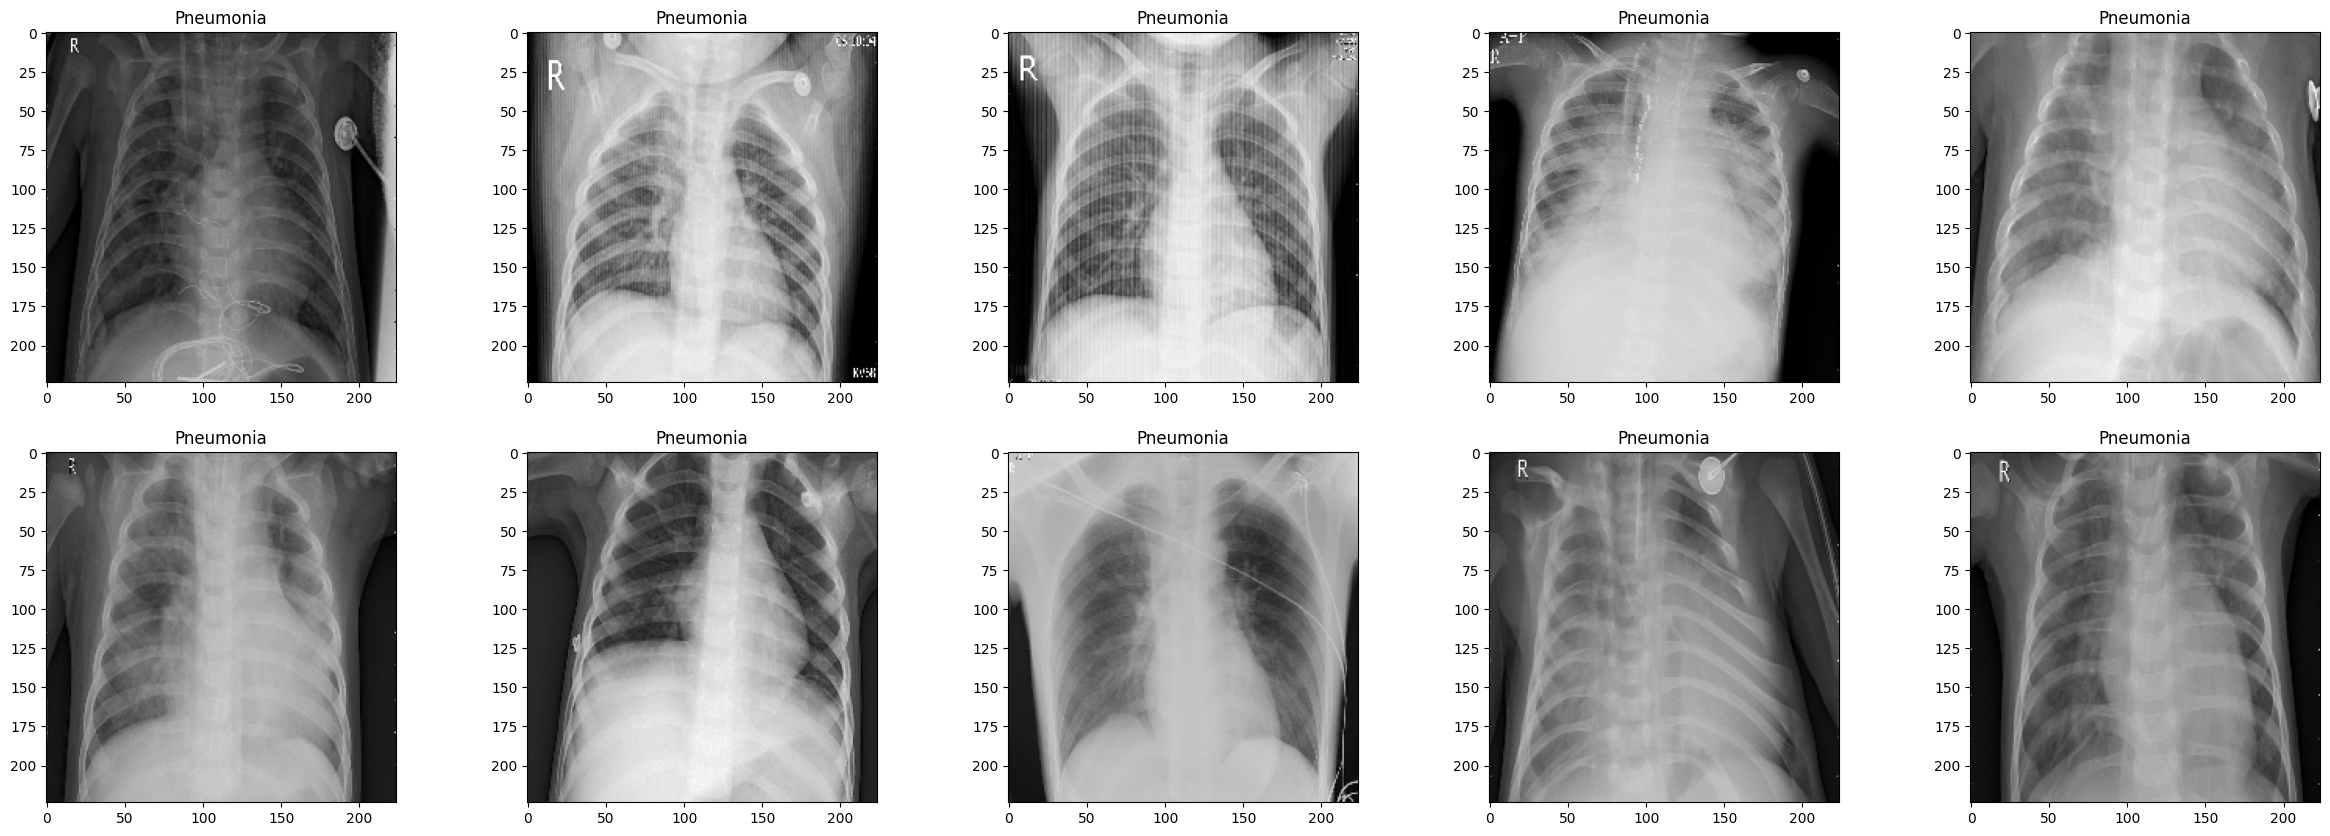

In [12]:
#Visualize the images in the train set
fig = plt.figure(figsize=(30, 10))
fig.subplots_adjust(hspace=0.2)
k=1
for i in range(10):
    a = fig.add_subplot(2, 5, k)
    if (y[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')

    plt.imshow(X[i], cmap='gray')
    k=k+1;

In [13]:
#Create a CNN model - BASELINE MODEL
#Import necessary library
import tensorflow as tf
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.layers import Dropout
from tensorflow.keras.losses import binary_crossentropy


#Define the CNN architecture - 3 ConV layers(32, 64, 128 filters; 3x3) using ReLU activation function, 3 MaxPool layers(2x2),
#                              1 drropout layer, 1 FC layer 256 neurons, and output layer using sigmoid function
main_model = models.Sequential()

main_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))

main_model.add(layers.MaxPooling2D((2, 2)))

main_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

main_model.add(layers.MaxPooling2D((2, 2)))

main_model.add(layers.Conv2D(128, (3, 3), activation='relu'))

main_model.add(layers.MaxPooling2D((2, 2)))

main_model.add(Dropout(0.5))

main_model.add(layers.Flatten())

main_model.add(layers.Dense(256, activation=  'relu'))

main_model.add(layers.Dense(1,  activation = 'sigmoid'))

In [14]:
#Extract summary from model
main_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,353 (84.86 MB)

 Trainable params: 22,244,353 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#Compile the model
main_model.compile(optimizer='adam', loss= binary_crossentropy, metrics=['accuracy'])

In [16]:
#Convert the dataset into numpy array as the fit() expects an numpy array
X_train = np.array(X)
y_train = np.array(y)
X_test = np.array(A)
y_test = np.array(b)
X_val = np.array(C)
y_val = np.array(d)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(5216, 224, 224)
(5216,)
(624, 224, 224)
(624,)
(16, 224, 224)
(16,)


In [17]:
# Set a random seed for reproducibility
np.random.seed(10)

#Train the model
model_history = main_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.7876 - loss: 0.6290 - val_accuracy: 0.8750 - val_loss: 0.2691
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - accuracy: 0.9595 - loss: 0.1093 - val_accuracy: 0.6875 - val_loss: 0.3904
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.9641 - loss: 0.0889 - val_accuracy: 0.6875 - val_loss: 0.4227
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9696 - loss: 0.0781 - val_accuracy: 0.9375 - val_loss: 0.2089
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9765 - loss: 0.0614 - val_accuracy: 0.8750 - val_loss: 0.1689
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 275s 2s/step - accuracy: 0.9781 - loss: 0.0496 - val_accuracy: 1.0000 - val_loss: 0.1279
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9831 - loss: 0.0435 - val_accuracy: 1.0000 - val_loss: 0.0702
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9845 - loss: 0.0405 - val_accu

In [18]:
#Calculate the confusion matrix and performance matrix
#Import necessary library
from sklearn.metrics import accuracy_score, confusion_matrix

#Print out the confusion matrix and performance matrix
preds = main_model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))

tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\n============TEST METRICS=============')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 436ms/step
CONFUSION MATRIX ------------------
[[102 132]
 [  5 385]]

============TEST METRICS=============
Accuracy: 78.0448717948718%
Precision: 74.46808510638297%
Recall: 98.71794871794873%
F1-score: 84.89525909592061


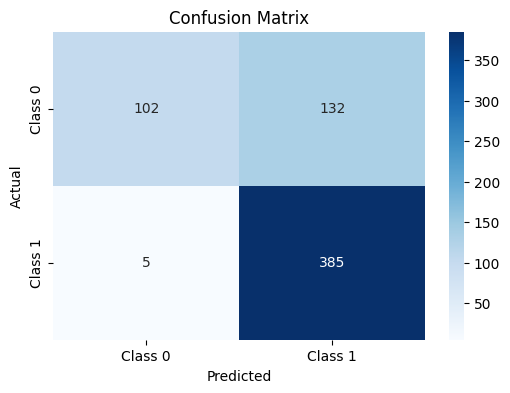

In [19]:
#Plot the confusion matrix
#Import necessary library
import seaborn as sns
# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
class_names = ['Class 0', 'Class 1'] 
plot_confusion_matrix(cm, class_names)

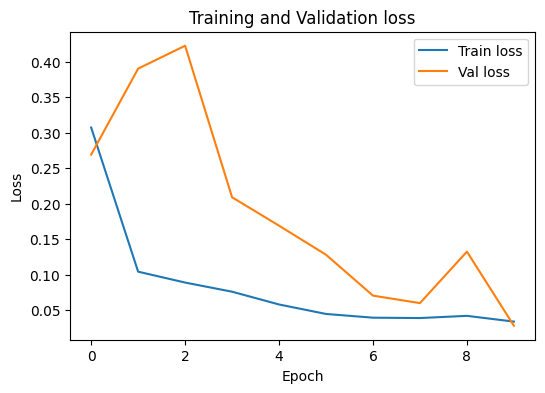

In [20]:
# Plot training & validation loss values
plt.figure(figsize=(6, 4))
plt.plot(model_history.history['loss'], label='Train loss')
plt.plot(model_history.history['val_loss'], label='Val loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

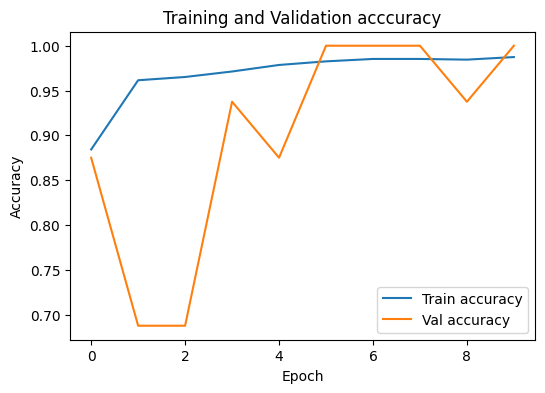

In [21]:
# Plot training & validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(model_history.history['accuracy'], label='Train accuracy')
plt.plot(model_history.history['val_accuracy'], label='Val accuracy')
plt.title('Training and Validation acccuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()